# **N-gram 언어 모델로 문장 생성하기**

파이썬의 NLTK 패키지를 이용하여 N-gram 언어 모델을 구축

In [1]:
import nltk # 자연어 처리를 위한 파이썬 패키지
from nltk.util import ngrams # n-grams 언어 모델
from nltk import word_tokenize # 토큰화

from nltk import ConditionalFreqDist # 각 문맥별 단어 빈도를 측정
# record the number of times each sample occurred, given the condition under which the experiment was run
from nltk.probability import ConditionalProbDist, MLEProbDist # 각 단어별 조건부 확률 추정
# ConditionalProbDist: modeling the experiments that were used to generate a conditional frequency distribution
# MLEProbDist: maximum likelihood estimate for the probability distribution of the experiment used to generate a frequency distribution

import numpy as np
import codecs
from tqdm import tqdm
import random

In [2]:
# 한국어 처리에 필요한 konlpy 패키지를 설치하기 전에 선행 파일을 설치한다. 
!apt-get update

!apt-get install g++ openjdk-8-jdk python-dev python3-dev

!pip3 install JPype1-py3

!pip3 install konlpy

!JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"

from konlpy.tag import Okt

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [73.4 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [923 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,018 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu 

## 실습 1. 'ngrams' 이용

In [3]:
# NLTK 패키지를 이용하여 입력 텍스트를 N-gram 형태로 변환
sentence = '자연어 처리 분석은 역시 어렵다'

In [4]:
# NLTK 사용을 위하여 선행 패키지를 설치
nltk.download('punkt')

# 입력 텍스트를 띄어쓰기 기준으로 토큰화
tokens = word_tokenize(sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
print(tokens)

['자연어', '처리', '분석은', '역시', '어렵다']


In [6]:
tagger = Okt()

def tokenize(text):
    tokens = ['/'.join(t) for t in tagger.pos(text)]
    return tokens

tokens = tokenize(sentence)
print(tokens)

['자연어/Noun', '처리/Noun', '분석/Noun', '은/Josa', '역시/Noun', '어렵다/Adjective']


## **Question 1**
- Q: N-gram을 통한 언어 모델에서는 다음에 나올 단어의 예측은 오직 n-1개의 단어에만 의존한다. 그렇다면 **unigram은 0개의 단어에만 의존..?**
- A: Unigram일 때는, 조건부 확률을 이용하지 않고 단어 자신만의 확률에 신경 씀

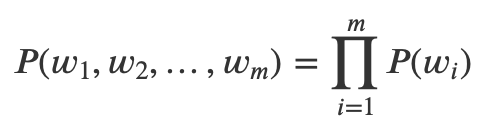

In [7]:
# 토큰을 N-gram의 형태로 바꿔줌
# n-grams 함수의 두번째 인자: N 값을 지정
bigram = ngrams(tokens, 2) # N = 2 -> bigram
trigram = ngrams(tokens, 3) # N = 3 -> trigram

In [8]:
# N-gram 출력
print('bigram: ')
for b in bigram:
  print(b)

print('\ntrigram: ')
for t in trigram:
  print(t)

bigram: 
('자연어/Noun', '처리/Noun')
('처리/Noun', '분석/Noun')
('분석/Noun', '은/Josa')
('은/Josa', '역시/Noun')
('역시/Noun', '어렵다/Adjective')

trigram: 
('자연어/Noun', '처리/Noun', '분석/Noun')
('처리/Noun', '분석/Noun', '은/Josa')
('분석/Noun', '은/Josa', '역시/Noun')
('은/Josa', '역시/Noun', '어렵다/Adjective')


In [9]:
# padding을 통해 입력 데이터에 문장의 시작+끝을 알리는 토큰 추가
bigram = ngrams(tokens, 2,
                pad_left = True, pad_right = True,
                left_pad_symbol='<s>', right_pad_symbol='</s>')
print('bigrams with padding: ')
for b in bigram:
  print(b)

bigrams with padding: 
('<s>', '자연어/Noun')
('자연어/Noun', '처리/Noun')
('처리/Noun', '분석/Noun')
('분석/Noun', '은/Josa')
('은/Josa', '역시/Noun')
('역시/Noun', '어렵다/Adjective')
('어렵다/Adjective', '</s>')


## 실습 2. 'everygrams' 이용

In [11]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends # 양쪽을 padding
from nltk.lm.preprocessing import flatten # 문자를 하나의 흐름으로 펼치기 위해 사용
# 모델은 자기가 알고있는 단어를 정의하는 어휘에 의존
# 그러한 어휘를 만들기 위해서는 1) padding 2) 문장을 하나로 합침

In [12]:
import nltk
nltk.download('all', quiet = True) # quiet = True로 하는 이유는 다운로드 되는 복잡한 내용 안 뜨게 하기 위함

True

In [13]:
text = [['I', 'love', 'dogs'], ['My', 'favorite', 'breed', 'is', 'golden', 'retriever']]

In [14]:
list(bigrams(text[0]))

[('I', 'love'), ('love', 'dogs')]

In [15]:
list(ngrams(text[1], n = 3))

[('My', 'favorite', 'breed'),
 ('favorite', 'breed', 'is'),
 ('breed', 'is', 'golden'),
 ('is', 'golden', 'retriever')]

### 문장의 시작('<s>')과 끝('</s>')을 나타내는 Padding 추가

In [16]:
from nltk.util import pad_sequence

list(pad_sequence(text[0],
                  pad_left = True, left_pad_symbol = '<s>',
                  pad_right = True, right_pad_symbol = '</s>',
                  n = 2))

['<s>', 'I', 'love', 'dogs', '</s>']

In [17]:
padded_sent = list(pad_sequence(text[0],
                  pad_left = True, left_pad_symbol = '<s>',
                  pad_right = True, right_pad_symbol = '</s>',
                  n = 2))

list(ngrams(padded_sent, n = 2))

[('<s>', 'I'), ('I', 'love'), ('love', 'dogs'), ('dogs', '</s>')]

### pad_both_ends 함수

In [18]:
from nltk.lm.preprocessing import pad_both_ends

list(pad_both_ends(text[0], n = 2))

['<s>', 'I', 'love', 'dogs', '</s>']

In [19]:
list(bigrams(pad_both_ends(text[0], n = 2)))

[('<s>', 'I'), ('I', 'love'), ('love', 'dogs'), ('dogs', '</s>')]

### everygrams: returns all possible ngrams generated from a sequence of items

In [20]:
from nltk.util import everygrams

padded_bigrams = list(pad_both_ends(text[0], n = 2))
print(padded_bigrams)
print(list(everygrams(padded_bigrams, max_len = 3)))

['<s>', 'I', 'love', 'dogs', '</s>']
[('<s>',), ('<s>', 'I'), ('<s>', 'I', 'love'), ('I',), ('I', 'love'), ('I', 'love', 'dogs'), ('love',), ('love', 'dogs'), ('love', 'dogs', '</s>'), ('dogs',), ('dogs', '</s>'), ('</s>',)]


### flatten: 모든 문자 펼치기

In [21]:
from nltk.lm.preprocessing import flatten

list(flatten(pad_both_ends(sent, n = 2) for sent in text))

['<s>',
 'I',
 'love',
 'dogs',
 '</s>',
 '<s>',
 'My',
 'favorite',
 'breed',
 'is',
 'golden',
 'retriever',
 '</s>']

In [22]:
from nltk.lm.preprocessing import padded_everygram_pipeline
training_ngrams, padded_sentences = padded_everygram_pipeline(2, text)
for ngramlize_sent in training_ngrams:
  print(list(ngramlize_sent))
  print()
print('################')
list(padded_sentences)

[('<s>',), ('<s>', 'I'), ('I',), ('I', 'love'), ('love',), ('love', 'dogs'), ('dogs',), ('dogs', '</s>'), ('</s>',)]

[('<s>',), ('<s>', 'My'), ('My',), ('My', 'favorite'), ('favorite',), ('favorite', 'breed'), ('breed',), ('breed', 'is'), ('is',), ('is', 'golden'), ('golden',), ('golden', 'retriever'), ('retriever',), ('retriever', '</s>'), ('</s>',)]

################


['<s>',
 'I',
 'love',
 'dogs',
 '</s>',
 '<s>',
 'My',
 'favorite',
 'breed',
 'is',
 'golden',
 'retriever',
 '</s>']

## 실습 3. 직접 n-gram function 만들어보기

In [23]:
def n_grams(text, n):
  '''
  takes tokens or text, returns a list of n-grams
  '''
  return [text[i:i+n] for i in range(len(text)-n+1)]

In [25]:
cleaned = ["mary", "," , "n't", "slap", "green", "witch", "."]
n_grams(cleaned, 3)

[['mary', ',', "n't"],
 [',', "n't", 'slap'],
 ["n't", 'slap', 'green'],
 ['slap', 'green', 'witch'],
 ['green', 'witch', '.']]

## 실습 4. 영화 리뷰 데이터셋을 이용해 문장을 생성

### bigram

In [57]:
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')
from nltk.corpus import movie_reviews

sentences = []
for tokens in movie_reviews.sents():
    bigram = ngrams(tokens, 2,
                    pad_left = True, pad_right = True,
                    left_pad_symbol = "<s>", right_pad_symbol = "</s>")
    sentences += [t for t in bigram]

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [58]:
sentences[:10]

[('<s>', 'plot'),
 ('plot', ':'),
 (':', 'two'),
 ('two', 'teen'),
 ('teen', 'couples'),
 ('couples', 'go'),
 ('go', 'to'),
 ('to', 'a'),
 ('a', 'church'),
 ('church', 'party')]

In [60]:
cfd = ConditionalFreqDist(sentences)
# most_common(): 어떠한 단어 뒤에 오는 단어들의 빈도수 출력
cfd["<s>"].most_common(5) # 문장의 처음(left padding을 <s>로 하여 문장의 시작을 알림)에 올 수 있는 단어들

[('the', 8071), ('.', 3173), ('it', 3136), ('i', 2471), ('but', 1814)]

In [62]:
cfd["teen"].most_common(5) # 'teen' 단어 뒤에 오는 단어들

[('-', 15), ('comedy', 12), ('angst', 8), ('horror', 8), ('slasher', 5)]

In [63]:
cfd["."].most_common(5) # '.' 뒤에 오는 단어들

[('</s>', 63404), ('"', 1854), (')', 535), ("'", 70), (']', 10)]

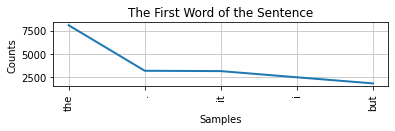

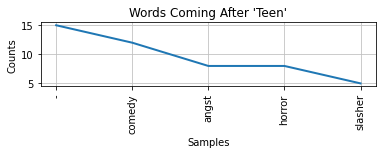

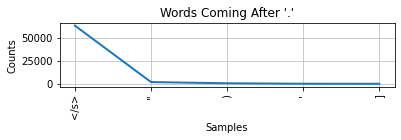

In [66]:
import matplotlib.pyplot as plt

plt.subplot(311)
cfd["<s>"].plot(5, title = "The First Word of the Sentence")
plt.subplot(312)
cfd["teen"].plot(5, title = "Words Coming After 'Teen'")
plt.subplot(313)
cfd["."].plot(5, title="Words Coming After '.'")

plt.show()

### ConditionalProbDist(): 조건부 확률 추정

In [70]:
# 단어별 등장 빈도를 기반으로 조건부 확률을 추정
cpd = ConditionalProbDist(cfd, MLEProbDist)

In [72]:
cpd["i"].prob("am") # 'i' 뒤에 'am'이 올 확률

0.018562267971650354

### bigram으로 문장 생성
- 조건부 확률을 알게 되면 각 문장의 확률을 구할 수 있음
- 전체 문장의 확률 = 조건부 확률의 곱
ex) P(<s> I love dogs </s>) = P(I|<s>)P(love|I)P(dogs|love)P(</s>|dogs)


In [75]:
# 문장(단어 리스트)의 리스트 만들기
def sentence_score(s):
  p = 0.0
  for i in range(len(s) - 1):
      c = s[i]
      w = s[i + 1]
      p += np.log(cpd[c].prob(w) + np.finfo(float).eps)
  return np.exp(p)

In [76]:
test_sentence = ["I", "enjoyed", "watching", "the", "movie", "."]
sentence_score(test_sentence)

3.926133717796737e-21

In [77]:
test_sentence = ["like", "i", "the", ".", "movie"]
sentence_score(test_sentence)

1.5015040140827832e-38

In [78]:
# 임의의 랜덤한 문장 생성
def generate_sentence(seed = None):
    if seed is not None:
        import random
        random.seed(seed)
    c = "<s>" # 시작 (left padding)
    sentence = []
    while True:
        if c not in cpd:
            break
        w = cpd[c].generate()

        if w == "</s>": # 끝 (right padding)
            break
        elif w in ["i", "ii", "iii"]:
            w2 = w.upper()
        elif w in ["mr", "luc", "i", "robin", "williams", "cindy", "crawford"]:
            w2 = w.title()
        else:
            w2 = w

        if c == "<s>":
            sentence.append(w2.title())
        elif c in ["`", "\"", "'", "("]:
            sentence.append(w2)
        elif w in ["'", ".", ",", ")", ":", ";", "?"]:
            sentence.append(w2)
        else:
            sentence.append(" " + w2)

        c = w
    return "".join(sentence)

In [79]:
generate_sentence(6)

"Writers in one of the prison, yet, works as agent ray liotta, one of watching, we supposed to doubt that the holocaust - or the fact, the amc and don's wonderful experience, do what could either."

### + **한글 자료 이용**
##Naver sentiment movie corpus 자료 사용

In [82]:
%%time
# 걸리는 시간 보여주기 위함
!wget -nc -q https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt # 데이터 다운로드

CPU times: user 5.39 ms, sys: 39 ms, total: 44.4 ms
Wall time: 165 ms


In [83]:
import codecs
with codecs.open("ratings_train.txt", encoding='utf-8') as f:
    data = [line.split('\t') for line in f.read().splitlines()]
    data = data[1:]   # header 제외

docs = [row[1] for row in data] # 데이터 저장
len(docs)

150000

In [84]:
import warnings
warnings.simplefilter("ignore")

from konlpy.tag import Okt

tagger = Okt()

def tokenize(doc):
    tokens = ['/'.join(t) for t in tagger.pos(doc)]
    return tokens

tokenize("그 영화는 아주 재미있었어요.")

['그/Noun', '영화/Noun', '는/Josa', '아주/Noun', '재미있었어요/Adjective', './Punctuation']

In [86]:
from tqdm import tqdm # progress bar 보여줌
sentences = []
for d in tqdm(docs):
    tokens = tokenize(d)
    bigram = ngrams(tokens, 2,
                    pad_left = True, pad_right = True,
                    left_pad_symbol = "<s>", right_pad_symbol = "</s>")
    sentences += [t for t in bigram]

100%|██████████| 150000/150000 [13:27<00:00, 185.80it/s]


In [87]:
sentences[:10]

[('<s>', '아/Exclamation'),
 ('아/Exclamation', '더빙/Noun'),
 ('더빙/Noun', '../Punctuation'),
 ('../Punctuation', '진짜/Noun'),
 ('진짜/Noun', '짜증나네요/Adjective'),
 ('짜증나네요/Adjective', '목소리/Noun'),
 ('목소리/Noun', '</s>'),
 ('<s>', '흠/Noun'),
 ('흠/Noun', '.../Punctuation'),
 ('.../Punctuation', '포스터/Noun')]

In [88]:
cfd = ConditionalFreqDist(sentences)
cpd = ConditionalProbDist(cfd, MLEProbDist)

def korean_most_common(c, n, pos = None):
  if pos is None:
      return cfd[tokenize(c)[0]].most_common(n)
  else:
      return cfd["/".join([c, pos])].most_common(n)

In [89]:
korean_most_common("나", 10)

[('는/Josa', 831),
 ('의/Josa', 339),
 ('만/Josa', 213),
 ('에게/Josa', 148),
 ('에겐/Josa', 84),
 ('랑/Josa', 81),
 ('한테/Josa', 50),
 ('참/Verb', 45),
 ('이/Determiner', 44),
 ('와도/Josa', 43)]

In [90]:
korean_most_common(".", 10, "Punctuation")

[('</s>', 26503),
 ('영화/Noun', 667),
 ('이/Noun', 565),
 ('정말/Noun', 480),
 ('그리고/Conjunction', 455),
 ('./Punctuation', 445),
 ('하지만/Conjunction', 369),
 ('이/Determiner', 352),
 ('그/Noun', 325),
 ('스토리/Noun', 317)]

In [91]:
def korean_bigram_prob(c, w):
  context = tokenize(c)[0]
  word = tokenize(w)[0]
  return cpd[context].prob(word)

In [92]:
korean_bigram_prob("이", "영화")

0.4010748656417948

In [93]:
# 단어 순서 바뀌면 확률 값의 변화 살펴볼 것
korean_bigram_prob("영화", "이")

0.00015767585785521414

In [94]:
def korean_generate_sentence(seed=None, debug=False):
    if seed is not None:
        import random
        random.seed(seed)
    c = "<s>"
    sentence = []
    while True:
        if c not in cpd:
            break
            
        w = cpd[c].generate()

        if w == "</s>":
            break

        w2 = w.split("/")[0]
        pos = w.split("/")[1]

        if c == "<s>":
            sentence.append(w2.title())
        elif c in ["`", "\"", "'", "("]:
            sentence.append(w2)
        elif w2 in ["'", ".", ",", ")", ":", ";", "?"]:
            sentence.append(w2)
        elif pos in ["Josa", "Punctuation", "Suffix"]:
            sentence.append(w2)
        elif w in ["임/Noun", "것/Noun", "는걸/Noun", "릴때/Noun",
                   "되다/Verb", "이다/Verb", "하다/Verb", "이다/Adjective"]:
            sentence.append(w2)
        else:
            sentence.append(" " + w2)
        c = w

        if debug:
            print(w)

    return "".join(sentence)

In [95]:
korean_generate_sentence(0)

'미키짱과 말도 전혀 빗나가지 않던 전개로 꽥꽥대는거 보니까 요^^'

In [96]:
korean_generate_sentence(1)

'내용 일테인데 이 영화 최고의 암살 할려고 한 데 선배랑 김선아 연기도 크다. 배슬기 여배우도 있는 척 하는거지?'

In [97]:
korean_generate_sentence(3)

'내 인생을 반헬싱이 너무 무섭고 재밌고, 칼 세이건으로 연탄가스 맡아서 죽을 같이 작업 하는구나 ㅋㅋㅋㅋㅋ 진짜'